# Create routes from all Bixi stations to all Bixi stations via Bixi lanes
(and if that is too costly computationally, take a sample)

In [1]:
# import dependencies
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd

import json
import pickle

import geopandas as gpd
from shapely.geometry import Polygon

In [2]:
ox.config(log_console=True, use_cache=True)
station_dict = pd.read_csv('../data/bixi/BixiMontrealRentals2018/Stations_2018_Plateau.csv',index_col=0).T.to_dict()

In [3]:
# place_name = 'Plateau Mont Royal, Montreal, Quebec, Canada'
sg = ox.graph_from_bbox(south=45.5029722, north=45.5412594, west=-73.6120455, east=-73.5593741, network_type = 'bike')
sg_proj = ox.project_graph(sg)

In [8]:
# LISA: 	6047 to 6248

# THOMAS: 6021 to 6047
#       6186 to 6216

codes = [(6047,6248),(6021,6047),(6186,6216)]
route = []
    
for code1,code2 in codes:
    temp1 = station_dict[code1]; temp2 = station_dict[code2]

    (alat,alon) = temp1['latitude'],temp1['longitude']
    (blat,blon) = temp2['latitude'],temp2['longitude']

    origin = ox.get_nearest_node(sg, (alat, alon),method = 'euclidean')
    destination = ox.get_nearest_node(sg, (blat, blon),method = 'euclidean')

    route.append(nx.shortest_path(sg, source=origin, target=destination, weight='length'))

print(route)
# fig, ax = ox.plot_graph_route(sg_proj, route)

[[29793980, 1573503367, 29793981, 31706267, 31706264, 31706262, 31706123, 31706063, 355412789, 31705442, 1374347245, 30453005, 1778791554, 31777145, 31776848, 2342893152, 1571427824, 31701566, 29794080, 31777081, 133342201], [31776825, 31776824, 208932423, 31776823, 29794074, 237603328, 29794075, 31701556, 31776840, 678766347, 31776467, 678766338, 31776143, 3567553225, 1575102816, 124062159, 1575107329, 124062156, 1575107335, 124062151, 3565449794, 124062147, 3565293691, 124066839, 3565294793, 3566581582, 3566581583, 1573497813, 29793980], [3604845054, 3604845283, 3604845284, 209451593, 3606432448, 2148388097, 209459389, 209046789, 209046786, 209046783, 209046781, 31776989, 1562478901, 209046799, 209046797, 209046795, 31777188, 209046791, 237599901, 182070153, 182070154, 26232418, 209424667, 237602087, 237602091, 209046764, 26232424, 209049348, 209046761, 1653821650, 26232426, 26232428, 1859173330, 31701547, 26232430, 26232432, 3383056853, 127986323, 127970525, 437736342, 596988556, 31

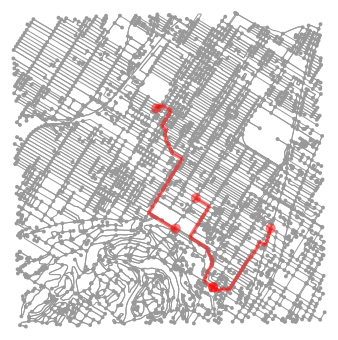

In [13]:
fig, ax = ox.plot_graph_routes(sg_proj, route)

In [10]:
def plot_graph_routes(G, routes, bbox=None, fig_height=6, fig_width=None,
                      margin=0.02, bgcolor='w', axis_off=True, show=True,
                      save=False, close=True, file_format='png', filename='temp',
                      dpi=300, annotate=False, node_color='#999999',
                      node_size=15, node_alpha=1, node_edgecolor='none',
                      node_zorder=1, edge_color='#999999', edge_linewidth=1,
                      edge_alpha=1, use_geom=True, orig_dest_points=None,
                      route_color='r', route_linewidth=4,
                      route_alpha=0.5, orig_dest_node_alpha=0.5,
                      orig_dest_node_size=100, orig_dest_node_color='r',
                      orig_dest_point_color='b'):
    """
    Plot several routes along a networkx spatial graph.
     Parameters
    ----------
    G : networkx multidigraph
    routes : list
        the routes as a list of lists of nodes
    bbox : tuple
        bounding box as north,south,east,west - if None will calculate from
        spatial extents of data. if passing a bbox, you probably also want to
        pass margin=0 to constrain it.
    fig_height : int
        matplotlib figure height in inches
    fig_width : int
        matplotlib figure width in inches
    margin : float
        relative margin around the figure
    axis_off : bool
        if True turn off the matplotlib axis
    bgcolor : string
        the background color of the figure and axis
    show : bool
        if True, show the figure
    save : bool
        if True, save the figure as an image file to disk
    close : bool
        close the figure (only if show equals False) to prevent display
    file_format : string
        the format of the file to save (e.g., 'jpg', 'png', 'svg')
    filename : string
        the name of the file if saving
    dpi : int
        the resolution of the image file if saving
    annotate : bool
        if True, annotate the nodes in the figure
    node_color : string
        the color of the nodes
    node_size : int
        the size of the nodes
    node_alpha : float
        the opacity of the nodes
    node_edgecolor : string
        the color of the node's marker's border
    node_zorder : int
        zorder to plot nodes, edges are always 2, so make node_zorder 1 to plot
        nodes beneath them or 3 to plot nodes atop them
    edge_color : string
        the color of the edges' lines
    edge_linewidth : float
        the width of the edges' lines
    edge_alpha : float
        the opacity of the edges' lines
    use_geom : bool
        if True, use the spatial geometry attribute of the edges to draw
        geographically accurate edges, rather than just lines straight from node
        to node
    orig_dest_points : list of tuples
        optional, a group of (lat, lon) points to plot instead of the
        origins and destinations of each route nodes
    route_color : string
        the color of the route
    route_linewidth : int
        the width of the route line
    route_alpha : float
        the opacity of the route line
    orig_dest_node_alpha : float
        the opacity of the origin and destination nodes
    orig_dest_node_size : int
        the size of the origin and destination nodes
    orig_dest_node_color : string
        the color of the origin and destination nodes
    orig_dest_point_color : string
        the color of the origin and destination points if being plotted instead
        of nodes
     Returns
    -------
    fig, ax : tuple
    """
     # plot the graph but not the routes
    fig, ax = plot_graph(G, bbox=bbox, fig_height=fig_height, fig_width=fig_width,
                         margin=margin, axis_off=axis_off, bgcolor=bgcolor,
                         show=False, save=False, close=False, filename=filename,
                         dpi=dpi, annotate=annotate, node_color=node_color,
                         node_size=node_size, node_alpha=node_alpha,
                         node_edgecolor=node_edgecolor, node_zorder=node_zorder,
                         edge_color=edge_color, edge_linewidth=edge_linewidth,
                         edge_alpha=edge_alpha, use_geom=use_geom)
     # save coordinates of the given reference points
    orig_dest_points_lats = []
    orig_dest_points_lons = []
    if orig_dest_points is None:
        # if caller didn't pass points, use the first and last node in each route as
        # origin/destination points
        for route in routes:
            origin_node = route[0]
            destination_node = route[-1]
            orig_dest_points_lats.append(G.nodes[origin_node]['y'])
            orig_dest_points_lats.append(G.nodes[destination_node]['y'])
            orig_dest_points_lons.append(G.nodes[origin_node]['x'])
            orig_dest_points_lons.append(G.nodes[destination_node]['x'])
    else:
        # otherwise, use the passed points as origin/destination points
        for point in orig_dest_points:
            orig_dest_points_lats.append(point[0])
            orig_dest_points_lons.append(point[1])
        orig_dest_node_color = orig_dest_point_color
     # scatter the origin and destination points
    ax.scatter(orig_dest_points_lons, orig_dest_points_lats, s=orig_dest_node_size,
               c=orig_dest_node_color, alpha=orig_dest_node_alpha, edgecolor=node_edgecolor, zorder=4)
     # plot the routes lines
    lines = []
    for route in routes:
        edge_nodes = list(zip(route[:-1], route[1:]))
        for u, v in edge_nodes:
            # if there are parallel edges, select the shortest in length
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])
             # if it has a geometry attribute (ie, a list of line segments)
            if 'geometry' in data and use_geom:
                # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                # if it doesn't have a geometry attribute, the edge is a straight
                # line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
     # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors=route_color, linewidths=route_linewidth, alpha=route_alpha, zorder=3)
    ax.add_collection(lc)
     # save and show the figure as specified
    fig, ax = save_and_show(fig, ax, save, show, close, filename, file_format, dpi, axis_off)
    return fig, ax


In [12]:
fig, ax = ox.plot_graph_routes(sg_proj, route, origin_point=origin, destination_point=destination)

TypeError: plot_graph_routes() got an unexpected keyword argument 'origin_point'

In [5]:
# data = []
dic = {}

for i,code1 in enumerate(station_dict.keys()):

    for j,code2 in enumerate(station_dict.keys()):
        
        if code1 == code2:
            continue
            
        print(i,j)

        temp1 = station_dict[code1]; temp2 = station_dict[code2]

        (alat,alon) = temp1['latitude'],temp1['longitude']
        (blat,blon) = temp2['latitude'],temp2['longitude']

        origin = ox.get_nearest_node(sg, (alat, alon),method = 'euclidean')
        destination = ox.get_nearest_node(sg, (blat, blon),method = 'euclidean')

        route = nx.shortest_path(sg, source=origin, target=destination, weight='length')
        
        coords = [[sg_proj.node[route[i]]['lat'],sg_proj.node[route[i]]['lon']] for i in range(len(route))]
        name = str(code1)+'to'+str(code2)
        
        dic[name] = coords
        
#         dic['name'] = name
#         dic['positions'] = coords
        
#         data.append(dic)

# output = {'routes':data}

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184
0 18

7 154
7 155
7 156
7 157
7 158
7 159
7 160
7 161
7 162
7 163
7 164
7 165
7 166
7 167
7 168
7 169
7 170
7 171
7 172
7 173
7 174
7 175
7 176
7 177
7 178
7 179
7 180
7 181
7 182
7 183
7 184
7 185
7 186
7 187
7 188
7 189
7 190
7 191
7 192
7 193
7 194
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
8 20
8 21
8 22
8 23
8 24
8 25
8 26
8 27
8 28
8 29
8 30
8 31
8 32
8 33
8 34
8 35
8 36
8 37
8 38
8 39
8 40
8 41
8 42
8 43
8 44
8 45
8 46
8 47
8 48
8 49
8 50
8 51
8 52
8 53
8 54
8 55
8 56
8 57
8 58
8 59
8 60
8 61
8 62
8 63
8 64
8 65
8 66
8 67
8 68
8 69
8 70
8 71
8 72
8 73
8 74
8 75
8 76
8 77
8 78
8 79
8 80
8 81
8 82
8 83
8 84
8 85
8 86
8 87
8 88
8 89
8 90
8 91
8 92
8 93
8 94
8 95
8 96
8 97
8 98
8 99
8 100
8 101
8 102
8 103
8 104
8 105
8 106
8 107
8 108
8 109
8 110
8 111
8 112
8 113
8 114
8 115
8 116
8 117
8 118
8 119
8 120
8 121
8 122
8 123
8 124
8 125
8 126
8 127
8 128
8 129
8 130
8 131
8 132
8 133
8 134
8 135
8 136
8 137
8 138
8 139
8 140
8 141
8 142
8 143
8 14

14 148
14 149
14 150
14 151
14 152
14 153
14 154
14 155
14 156
14 157
14 158
14 159
14 160
14 161
14 162
14 163
14 164
14 165
14 166
14 167
14 168
14 169
14 170
14 171
14 172
14 173
14 174
14 175
14 176
14 177
14 178
14 179
14 180
14 181
14 182
14 183
14 184
14 185
14 186
14 187
14 188
14 189
14 190
14 191
14 192
14 193
14 194
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
15 12
15 13
15 14
15 16
15 17
15 18
15 19
15 20
15 21
15 22
15 23
15 24
15 25
15 26
15 27
15 28
15 29
15 30
15 31
15 32
15 33
15 34
15 35
15 36
15 37
15 38
15 39
15 40
15 41
15 42
15 43
15 44
15 45
15 46
15 47
15 48
15 49
15 50
15 51
15 52
15 53
15 54
15 55
15 56
15 57
15 58
15 59
15 60
15 61
15 62
15 63
15 64
15 65
15 66
15 67
15 68
15 69
15 70
15 71
15 72
15 73
15 74
15 75
15 76
15 77
15 78
15 79
15 80
15 81
15 82
15 83
15 84
15 85
15 86
15 87
15 88
15 89
15 90
15 91
15 92
15 93
15 94
15 95
15 96
15 97
15 98
15 99
15 100
15 101
15 102
15 103
15 104
15 105
15 106
15 107
15 108
15 109
15 110
15 111
15 

21 65
21 66
21 67
21 68
21 69
21 70
21 71
21 72
21 73
21 74
21 75
21 76
21 77
21 78
21 79
21 80
21 81
21 82
21 83
21 84
21 85
21 86
21 87
21 88
21 89
21 90
21 91
21 92
21 93
21 94
21 95
21 96
21 97
21 98
21 99
21 100
21 101
21 102
21 103
21 104
21 105
21 106
21 107
21 108
21 109
21 110
21 111
21 112
21 113
21 114
21 115
21 116
21 117
21 118
21 119
21 120
21 121
21 122
21 123
21 124
21 125
21 126
21 127
21 128
21 129
21 130
21 131
21 132
21 133
21 134
21 135
21 136
21 137
21 138
21 139
21 140
21 141
21 142
21 143
21 144
21 145
21 146
21 147
21 148
21 149
21 150
21 151
21 152
21 153
21 154
21 155
21 156
21 157
21 158
21 159
21 160
21 161
21 162
21 163
21 164
21 165
21 166
21 167
21 168
21 169
21 170
21 171
21 172
21 173
21 174
21 175
21 176
21 177
21 178
21 179
21 180
21 181
21 182
21 183
21 184
21 185
21 186
21 187
21 188
21 189
21 190
21 191
21 192
21 193
21 194
22 0
22 1
22 2
22 3
22 4
22 5
22 6
22 7
22 8
22 9
22 10
22 11
22 12
22 13
22 14
22 15
22 16
22 17
22 18
22 19
22 20
22 21
22 

27 176
27 177
27 178
27 179
27 180
27 181
27 182
27 183
27 184
27 185
27 186
27 187
27 188
27 189
27 190
27 191
27 192
27 193
27 194
28 0
28 1
28 2
28 3
28 4
28 5
28 6
28 7
28 8
28 9
28 10
28 11
28 12
28 13
28 14
28 15
28 16
28 17
28 18
28 19
28 20
28 21
28 22
28 23
28 24
28 25
28 26
28 27
28 29
28 30
28 31
28 32
28 33
28 34
28 35
28 36
28 37
28 38
28 39
28 40
28 41
28 42
28 43
28 44
28 45
28 46
28 47
28 48
28 49
28 50
28 51
28 52
28 53
28 54
28 55
28 56
28 57
28 58
28 59
28 60
28 61
28 62
28 63
28 64
28 65
28 66
28 67
28 68
28 69
28 70
28 71
28 72
28 73
28 74
28 75
28 76
28 77
28 78
28 79
28 80
28 81
28 82
28 83
28 84
28 85
28 86
28 87
28 88
28 89
28 90
28 91
28 92
28 93
28 94
28 95
28 96
28 97
28 98
28 99
28 100
28 101
28 102
28 103
28 104
28 105
28 106
28 107
28 108
28 109
28 110
28 111
28 112
28 113
28 114
28 115
28 116
28 117
28 118
28 119
28 120
28 121
28 122
28 123
28 124
28 125
28 126
28 127
28 128
28 129
28 130
28 131
28 132
28 133
28 134
28 135
28 136
28 137
28 138
28 139
28 

34 102
34 103
34 104
34 105
34 106
34 107
34 108
34 109
34 110
34 111
34 112
34 113
34 114
34 115
34 116
34 117
34 118
34 119
34 120
34 121
34 122
34 123
34 124
34 125
34 126
34 127
34 128
34 129
34 130
34 131
34 132
34 133
34 134
34 135
34 136
34 137
34 138
34 139
34 140
34 141
34 142
34 143
34 144
34 145
34 146
34 147
34 148
34 149
34 150
34 151
34 152
34 153
34 154
34 155
34 156
34 157
34 158
34 159
34 160
34 161
34 162
34 163
34 164
34 165
34 166
34 167
34 168
34 169
34 170
34 171
34 172
34 173
34 174
34 175
34 176
34 177
34 178
34 179
34 180
34 181
34 182
34 183
34 184
34 185
34 186
34 187
34 188
34 189
34 190
34 191
34 192
34 193
34 194
35 0
35 1
35 2
35 3
35 4
35 5
35 6
35 7
35 8
35 9
35 10
35 11
35 12
35 13
35 14
35 15
35 16
35 17
35 18
35 19
35 20
35 21
35 22
35 23
35 24
35 25
35 26
35 27
35 28
35 29
35 30
35 31
35 32
35 33
35 34
35 36
35 37
35 38
35 39
35 40
35 41
35 42
35 43
35 44
35 45
35 46
35 47
35 48
35 49
35 50
35 51
35 52
35 53
35 54
35 55
35 56
35 57
35 58
35 59
35 60

41 19
41 20
41 21
41 22
41 23
41 24
41 25
41 26
41 27
41 28
41 29
41 30
41 31
41 32
41 33
41 34
41 35
41 36
41 37
41 38
41 39
41 40
41 42
41 43
41 44
41 45
41 46
41 47
41 48
41 49
41 50
41 51
41 52
41 53
41 54
41 55
41 56
41 57
41 58
41 59
41 60
41 61
41 62
41 63
41 64
41 65
41 66
41 67
41 68
41 69
41 70
41 71
41 72
41 73
41 74
41 75
41 76
41 77
41 78
41 79
41 80
41 81
41 82
41 83
41 84
41 85
41 86
41 87
41 88
41 89
41 90
41 91
41 92
41 93
41 94
41 95
41 96
41 97
41 98
41 99
41 100
41 101
41 102
41 103
41 104
41 105
41 106
41 107
41 108
41 109
41 110
41 111
41 112
41 113
41 114
41 115
41 116
41 117
41 118
41 119
41 120
41 121
41 122
41 123
41 124
41 125
41 126
41 127
41 128
41 129
41 130
41 131
41 132
41 133
41 134
41 135
41 136
41 137
41 138
41 139
41 140
41 141
41 142
41 143
41 144
41 145
41 146
41 147
41 148
41 149
41 150
41 151
41 152
41 153
41 154
41 155
41 156
41 157
41 158
41 159
41 160
41 161
41 162
41 163
41 164
41 165
41 166
41 167
41 168
41 169
41 170
41 171
41 172
41 173
41

47 133
47 134
47 135
47 136
47 137
47 138
47 139
47 140
47 141
47 142
47 143
47 144
47 145
47 146
47 147
47 148
47 149
47 150
47 151
47 152
47 153
47 154
47 155
47 156
47 157
47 158
47 159
47 160
47 161
47 162
47 163
47 164
47 165
47 166
47 167
47 168
47 169
47 170
47 171
47 172
47 173
47 174
47 175
47 176
47 177
47 178
47 179
47 180
47 181
47 182
47 183
47 184
47 185
47 186
47 187
47 188
47 189
47 190
47 191
47 192
47 193
47 194
48 0
48 1
48 2
48 3
48 4
48 5
48 6
48 7
48 8
48 9
48 10
48 11
48 12
48 13
48 14
48 15
48 16
48 17
48 18
48 19
48 20
48 21
48 22
48 23
48 24
48 25
48 26
48 27
48 28
48 29
48 30
48 31
48 32
48 33
48 34
48 35
48 36
48 37
48 38
48 39
48 40
48 41
48 42
48 43
48 44
48 45
48 46
48 47
48 49
48 50
48 51
48 52
48 53
48 54
48 55
48 56
48 57
48 58
48 59
48 60
48 61
48 62
48 63
48 64
48 65
48 66
48 67
48 68
48 69
48 70
48 71
48 72
48 73
48 74
48 75
48 76
48 77
48 78
48 79
48 80
48 81
48 82
48 83
48 84
48 85
48 86
48 87
48 88
48 89
48 90
48 91
48 92
48 93
48 94
48 95
48 96


54 47
54 48
54 49
54 50
54 51
54 52
54 53
54 55
54 56
54 57
54 58
54 59
54 60
54 61
54 62
54 63
54 64
54 65
54 66
54 67
54 68
54 69
54 70
54 71
54 72
54 73
54 74
54 75
54 76
54 77
54 78
54 79
54 80
54 81
54 82
54 83
54 84
54 85
54 86
54 87
54 88
54 89
54 90
54 91
54 92
54 93
54 94
54 95
54 96
54 97
54 98
54 99
54 100
54 101
54 102
54 103
54 104
54 105
54 106
54 107
54 108
54 109
54 110
54 111
54 112
54 113
54 114
54 115
54 116
54 117
54 118
54 119
54 120
54 121
54 122
54 123
54 124
54 125
54 126
54 127
54 128
54 129
54 130
54 131
54 132
54 133
54 134
54 135
54 136
54 137
54 138
54 139
54 140
54 141
54 142
54 143
54 144
54 145
54 146
54 147
54 148
54 149
54 150
54 151
54 152
54 153
54 154
54 155
54 156
54 157
54 158
54 159
54 160
54 161
54 162
54 163
54 164
54 165
54 166
54 167
54 168
54 169
54 170
54 171
54 172
54 173
54 174
54 175
54 176
54 177
54 178
54 179
54 180
54 181
54 182
54 183
54 184
54 185
54 186
54 187
54 188
54 189
54 190
54 191
54 192
54 193
54 194
55 0
55 1
55 2
55 3
55 

60 156
60 157
60 158
60 159
60 160
60 161
60 162
60 163
60 164
60 165
60 166
60 167
60 168
60 169
60 170
60 171
60 172
60 173
60 174
60 175
60 176
60 177
60 178
60 179
60 180
60 181
60 182
60 183
60 184
60 185
60 186
60 187
60 188
60 189
60 190
60 191
60 192
60 193
60 194
61 0
61 1
61 2
61 3
61 4
61 5
61 6
61 7
61 8
61 9
61 10
61 11
61 12
61 13
61 14
61 15
61 16
61 17
61 18
61 19
61 20
61 21
61 22
61 23
61 24
61 25
61 26
61 27
61 28
61 29
61 30
61 31
61 32
61 33
61 34
61 35
61 36
61 37
61 38
61 39
61 40
61 41
61 42
61 43
61 44
61 45
61 46
61 47
61 48
61 49
61 50
61 51
61 52
61 53
61 54
61 55
61 56
61 57
61 58
61 59
61 60
61 62
61 63
61 64
61 65
61 66
61 67
61 68
61 69
61 70
61 71
61 72
61 73
61 74
61 75
61 76
61 77
61 78
61 79
61 80
61 81
61 82
61 83
61 84
61 85
61 86
61 87
61 88
61 89
61 90
61 91
61 92
61 93
61 94
61 95
61 96
61 97
61 98
61 99
61 100
61 101
61 102
61 103
61 104
61 105
61 106
61 107
61 108
61 109
61 110
61 111
61 112
61 113
61 114
61 115
61 116
61 117
61 118
61 119
61 

67 79
67 80
67 81
67 82
67 83
67 84
67 85
67 86
67 87
67 88
67 89
67 90
67 91
67 92
67 93
67 94
67 95
67 96
67 97
67 98
67 99
67 100
67 101
67 102
67 103
67 104
67 105
67 106
67 107
67 108
67 109
67 110
67 111
67 112
67 113
67 114
67 115
67 116
67 117
67 118
67 119
67 120
67 121
67 122
67 123
67 124
67 125
67 126
67 127
67 128
67 129
67 130
67 131
67 132
67 133
67 134
67 135
67 136
67 137
67 138
67 139
67 140
67 141
67 142
67 143
67 144
67 145
67 146
67 147
67 148
67 149
67 150
67 151
67 152
67 153
67 154
67 155
67 156
67 157
67 158
67 159
67 160
67 161
67 162
67 163
67 164
67 165
67 166
67 167
67 168
67 169
67 170
67 171
67 172
67 173
67 174
67 175
67 176
67 177
67 178
67 179
67 180
67 181
67 182
67 183
67 184
67 185
67 186
67 187
67 188
67 189
67 190
67 191
67 192
67 193
67 194
68 0
68 1
68 2
68 3
68 4
68 5
68 6
68 7
68 8
68 9
68 10
68 11
68 12
68 13
68 14
68 15
68 16
68 17
68 18
68 19
68 20
68 21
68 22
68 23
68 24
68 25
68 26
68 27
68 28
68 29
68 30
68 31
68 32
68 33
68 34
68 35
68 

73 190
73 191
73 192
73 193
73 194
74 0
74 1
74 2
74 3
74 4
74 5
74 6
74 7
74 8
74 9
74 10
74 11
74 12
74 13
74 14
74 15
74 16
74 17
74 18
74 19
74 20
74 21
74 22
74 23
74 24
74 25
74 26
74 27
74 28
74 29
74 30
74 31
74 32
74 33
74 34
74 35
74 36
74 37
74 38
74 39
74 40
74 41
74 42
74 43
74 44
74 45
74 46
74 47
74 48
74 49
74 50
74 51
74 52
74 53
74 54
74 55
74 56
74 57
74 58
74 59
74 60
74 61
74 62
74 63
74 64
74 65
74 66
74 67
74 68
74 69
74 70
74 71
74 72
74 73
74 75
74 76
74 77
74 78
74 79
74 80
74 81
74 82
74 83
74 84
74 85
74 86
74 87
74 88
74 89
74 90
74 91
74 92
74 93
74 94
74 95
74 96
74 97
74 98
74 99
74 100
74 101
74 102
74 103
74 104
74 105
74 106
74 107
74 108
74 109
74 110
74 111
74 112
74 113
74 114
74 115
74 116
74 117
74 118
74 119
74 120
74 121
74 122
74 123
74 124
74 125
74 126
74 127
74 128
74 129
74 130
74 131
74 132
74 133
74 134
74 135
74 136
74 137
74 138
74 139
74 140
74 141
74 142
74 143
74 144
74 145
74 146
74 147
74 148
74 149
74 150
74 151
74 152
74 153
74 

80 115
80 116
80 117
80 118
80 119
80 120
80 121
80 122
80 123
80 124
80 125
80 126
80 127
80 128
80 129
80 130
80 131
80 132
80 133
80 134
80 135
80 136
80 137
80 138
80 139
80 140
80 141
80 142
80 143
80 144
80 145
80 146
80 147
80 148
80 149
80 150
80 151
80 152
80 153
80 154
80 155
80 156
80 157
80 158
80 159
80 160
80 161
80 162
80 163
80 164
80 165
80 166
80 167
80 168
80 169
80 170
80 171
80 172
80 173
80 174
80 175
80 176
80 177
80 178
80 179
80 180
80 181
80 182
80 183
80 184
80 185
80 186
80 187
80 188
80 189
80 190
80 191
80 192
80 193
80 194
81 0
81 1
81 2
81 3
81 4
81 5
81 6
81 7
81 8
81 9
81 10
81 11
81 12
81 13
81 14
81 15
81 16
81 17
81 18
81 19
81 20
81 21
81 22
81 23
81 24
81 25
81 26
81 27
81 28
81 29
81 30
81 31
81 32
81 33
81 34
81 35
81 36
81 37
81 38
81 39
81 40
81 41
81 42
81 43
81 44
81 45
81 46
81 47
81 48
81 49
81 50
81 51
81 52
81 53
81 54
81 55
81 56
81 57
81 58
81 59
81 60
81 61
81 62
81 63
81 64
81 65
81 66
81 67
81 68
81 69
81 70
81 71
81 72
81 73
81 74


87 34
87 35
87 36
87 37
87 38
87 39
87 40
87 41
87 42
87 43
87 44
87 45
87 46
87 47
87 48
87 49
87 50
87 51
87 52
87 53
87 54
87 55
87 56
87 57
87 58
87 59
87 60
87 61
87 62
87 63
87 64
87 65
87 66
87 67
87 68
87 69
87 70
87 71
87 72
87 73
87 74
87 75
87 76
87 77
87 78
87 79
87 80
87 81
87 82
87 83
87 84
87 85
87 86
87 88
87 89
87 90
87 91
87 92
87 93
87 94
87 95
87 96
87 97
87 98
87 99
87 100
87 101
87 102
87 103
87 104
87 105
87 106
87 107
87 108
87 109
87 110
87 111
87 112
87 113
87 114
87 115
87 116
87 117
87 118
87 119
87 120
87 121
87 122
87 123
87 124
87 125
87 126
87 127
87 128
87 129
87 130
87 131
87 132
87 133
87 134
87 135
87 136
87 137
87 138
87 139
87 140
87 141
87 142
87 143
87 144
87 145
87 146
87 147
87 148
87 149
87 150
87 151
87 152
87 153
87 154
87 155
87 156
87 157
87 158
87 159
87 160
87 161
87 162
87 163
87 164
87 165
87 166
87 167
87 168
87 169
87 170
87 171
87 172
87 173
87 174
87 175
87 176
87 177
87 178
87 179
87 180
87 181
87 182
87 183
87 184
87 185
87 186
8

93 155
93 156
93 157
93 158
93 159
93 160
93 161
93 162
93 163
93 164
93 165
93 166
93 167
93 168
93 169
93 170
93 171
93 172
93 173
93 174
93 175
93 176
93 177
93 178
93 179
93 180
93 181
93 182
93 183
93 184
93 185
93 186
93 187
93 188
93 189
93 190
93 191
93 192
93 193
93 194
94 0
94 1
94 2
94 3
94 4
94 5
94 6
94 7
94 8
94 9
94 10
94 11
94 12
94 13
94 14
94 15
94 16
94 17
94 18
94 19
94 20
94 21
94 22
94 23
94 24
94 25
94 26
94 27
94 28
94 29
94 30
94 31
94 32
94 33
94 34
94 35
94 36
94 37
94 38
94 39
94 40
94 41
94 42
94 43
94 44
94 45
94 46
94 47
94 48
94 49
94 50
94 51
94 52
94 53
94 54
94 55
94 56
94 57
94 58
94 59
94 60
94 61
94 62
94 63
94 64
94 65
94 66
94 67
94 68
94 69
94 70
94 71
94 72
94 73
94 74
94 75
94 76
94 77
94 78
94 79
94 80
94 81
94 82
94 83
94 84
94 85
94 86
94 87
94 88
94 89
94 90
94 91
94 92
94 93
94 95
94 96
94 97
94 98
94 99
94 100
94 101
94 102
94 103
94 104
94 105
94 106
94 107
94 108
94 109
94 110
94 111
94 112
94 113
94 114
94 115
94 116
94 117
94 118
94 

100 75
100 76
100 77
100 78
100 79
100 80
100 81
100 82
100 83
100 84
100 85
100 86
100 87
100 88
100 89
100 90
100 91
100 92
100 93
100 94
100 95
100 96
100 97
100 98
100 99
100 101
100 102
100 103
100 104
100 105
100 106
100 107
100 108
100 109
100 110
100 111
100 112
100 113
100 114
100 115
100 116
100 117
100 118
100 119
100 120
100 121
100 122
100 123
100 124
100 125
100 126
100 127
100 128
100 129
100 130
100 131
100 132
100 133
100 134
100 135
100 136
100 137
100 138
100 139
100 140
100 141
100 142
100 143
100 144
100 145
100 146
100 147
100 148
100 149
100 150
100 151
100 152
100 153
100 154
100 155
100 156
100 157
100 158
100 159
100 160
100 161
100 162
100 163
100 164
100 165
100 166
100 167
100 168
100 169
100 170
100 171
100 172
100 173
100 174
100 175
100 176
100 177
100 178
100 179
100 180
100 181
100 182
100 183
100 184
100 185
100 186
100 187
100 188
100 189
100 190
100 191
100 192
100 193
100 194
101 0
101 1
101 2
101 3
101 4
101 5
101 6
101 7
101 8
101 9
101 10
101 11

106 18
106 19
106 20
106 21
106 22
106 23
106 24
106 25
106 26
106 27
106 28
106 29
106 30
106 31
106 32
106 33
106 34
106 35
106 36
106 37
106 38
106 39
106 40
106 41
106 42
106 43
106 44
106 45
106 46
106 47
106 48
106 49
106 50
106 51
106 52
106 53
106 54
106 55
106 56
106 57
106 58
106 59
106 60
106 61
106 62
106 63
106 64
106 65
106 66
106 67
106 68
106 69
106 70
106 71
106 72
106 73
106 74
106 75
106 76
106 77
106 78
106 79
106 80
106 81
106 82
106 83
106 84
106 85
106 86
106 87
106 88
106 89
106 90
106 91
106 92
106 93
106 94
106 95
106 96
106 97
106 98
106 99
106 100
106 101
106 102
106 103
106 104
106 105
106 107
106 108
106 109
106 110
106 111
106 112
106 113
106 114
106 115
106 116
106 117
106 118
106 119
106 120
106 121
106 122
106 123
106 124
106 125
106 126
106 127
106 128
106 129
106 130
106 131
106 132
106 133
106 134
106 135
106 136
106 137
106 138
106 139
106 140
106 141
106 142
106 143
106 144
106 145
106 146
106 147
106 148
106 149
106 150
106 151
106 152
106 153
10

111 153
111 154
111 155
111 156
111 157
111 158
111 159
111 160
111 161
111 162
111 163
111 164
111 165
111 166
111 167
111 168
111 169
111 170
111 171
111 172
111 173
111 174
111 175
111 176
111 177
111 178
111 179
111 180
111 181
111 182
111 183
111 184
111 185
111 186
111 187
111 188
111 189
111 190
111 191
111 192
111 193
111 194
112 0
112 1
112 2
112 3
112 4
112 5
112 6
112 7
112 8
112 9
112 10
112 11
112 12
112 13
112 14
112 15
112 16
112 17
112 18
112 19
112 20
112 21
112 22
112 23
112 24
112 25
112 26
112 27
112 28
112 29
112 30
112 31
112 32
112 33
112 34
112 35
112 36
112 37
112 38
112 39
112 40
112 41
112 42
112 43
112 44
112 45
112 46
112 47
112 48
112 49
112 50
112 51
112 52
112 53
112 54
112 55
112 56
112 57
112 58
112 59
112 60
112 61
112 62
112 63
112 64
112 65
112 66
112 67
112 68
112 69
112 70
112 71
112 72
112 73
112 74
112 75
112 76
112 77
112 78
112 79
112 80
112 81
112 82
112 83
112 84
112 85
112 86
112 87
112 88
112 89
112 90
112 91
112 92
112 93
112 94
112 95
11

117 101
117 102
117 103
117 104
117 105
117 106
117 107
117 108
117 109
117 110
117 111
117 112
117 113
117 114
117 115
117 116
117 118
117 119
117 120
117 121
117 122
117 123
117 124
117 125
117 126
117 127
117 128
117 129
117 130
117 131
117 132
117 133
117 134
117 135
117 136
117 137
117 138
117 139
117 140
117 141
117 142
117 143
117 144
117 145
117 146
117 147
117 148
117 149
117 150
117 151
117 152
117 153
117 154
117 155
117 156
117 157
117 158
117 159
117 160
117 161
117 162
117 163
117 164
117 165
117 166
117 167
117 168
117 169
117 170
117 171
117 172
117 173
117 174
117 175
117 176
117 177
117 178
117 179
117 180
117 181
117 182
117 183
117 184
117 185
117 186
117 187
117 188
117 189
117 190
117 191
117 192
117 193
117 194
118 0
118 1
118 2
118 3
118 4
118 5
118 6
118 7
118 8
118 9
118 10
118 11
118 12
118 13
118 14
118 15
118 16
118 17
118 18
118 19
118 20
118 21
118 22
118 23
118 24
118 25
118 26
118 27
118 28
118 29
118 30
118 31
118 32
118 33
118 34
118 35
118 36
118 37


123 38
123 39
123 40
123 41
123 42
123 43
123 44
123 45
123 46
123 47
123 48
123 49
123 50
123 51
123 52
123 53
123 54
123 55
123 56
123 57
123 58
123 59
123 60
123 61
123 62
123 63
123 64
123 65
123 66
123 67
123 68
123 69
123 70
123 71
123 72
123 73
123 74
123 75
123 76
123 77
123 78
123 79
123 80
123 81
123 82
123 83
123 84
123 85
123 86
123 87
123 88
123 89
123 90
123 91
123 92
123 93
123 94
123 95
123 96
123 97
123 98
123 99
123 100
123 101
123 102
123 103
123 104
123 105
123 106
123 107
123 108
123 109
123 110
123 111
123 112
123 113
123 114
123 115
123 116
123 117
123 118
123 119
123 120
123 121
123 122
123 124
123 125
123 126
123 127
123 128
123 129
123 130
123 131
123 132
123 133
123 134
123 135
123 136
123 137
123 138
123 139
123 140
123 141
123 142
123 143
123 144
123 145
123 146
123 147
123 148
123 149
123 150
123 151
123 152
123 153
123 154
123 155
123 156
123 157
123 158
123 159
123 160
123 161
123 162
123 163
123 164
123 165
123 166
123 167
123 168
123 169
123 170
123 17

128 179
128 180
128 181
128 182
128 183
128 184
128 185
128 186
128 187
128 188
128 189
128 190
128 191
128 192
128 193
128 194
129 0
129 1
129 2
129 3
129 4
129 5
129 6
129 7
129 8
129 9
129 10
129 11
129 12
129 13
129 14
129 15
129 16
129 17
129 18
129 19
129 20
129 21
129 22
129 23
129 24
129 25
129 26
129 27
129 28
129 29
129 30
129 31
129 32
129 33
129 34
129 35
129 36
129 37
129 38
129 39
129 40
129 41
129 42
129 43
129 44
129 45
129 46
129 47
129 48
129 49
129 50
129 51
129 52
129 53
129 54
129 55
129 56
129 57
129 58
129 59
129 60
129 61
129 62
129 63
129 64
129 65
129 66
129 67
129 68
129 69
129 70
129 71
129 72
129 73
129 74
129 75
129 76
129 77
129 78
129 79
129 80
129 81
129 82
129 83
129 84
129 85
129 86
129 87
129 88
129 89
129 90
129 91
129 92
129 93
129 94
129 95
129 96
129 97
129 98
129 99
129 100
129 101
129 102
129 103
129 104
129 105
129 106
129 107
129 108
129 109
129 110
129 111
129 112
129 113
129 114
129 115
129 116
129 117
129 118
129 119
129 120
129 121
129 12

134 125
134 126
134 127
134 128
134 129
134 130
134 131
134 132
134 133
134 135
134 136
134 137
134 138
134 139
134 140
134 141
134 142
134 143
134 144
134 145
134 146
134 147
134 148
134 149
134 150
134 151
134 152
134 153
134 154
134 155
134 156
134 157
134 158
134 159
134 160
134 161
134 162
134 163
134 164
134 165
134 166
134 167
134 168
134 169
134 170
134 171
134 172
134 173
134 174
134 175
134 176
134 177
134 178
134 179
134 180
134 181
134 182
134 183
134 184
134 185
134 186
134 187
134 188
134 189
134 190
134 191
134 192
134 193
134 194
135 0
135 1
135 2
135 3
135 4
135 5
135 6
135 7
135 8
135 9
135 10
135 11
135 12
135 13
135 14
135 15
135 16
135 17
135 18
135 19
135 20
135 21
135 22
135 23
135 24
135 25
135 26
135 27
135 28
135 29
135 30
135 31
135 32
135 33
135 34
135 35
135 36
135 37
135 38
135 39
135 40
135 41
135 42
135 43
135 44
135 45
135 46
135 47
135 48
135 49
135 50
135 51
135 52
135 53
135 54
135 55
135 56
135 57
135 58
135 59
135 60
135 61
135 62
135 63
135 64
135

140 71
140 72
140 73
140 74
140 75
140 76
140 77
140 78
140 79
140 80
140 81
140 82
140 83
140 84
140 85
140 86
140 87
140 88
140 89
140 90
140 91
140 92
140 93
140 94
140 95
140 96
140 97
140 98
140 99
140 100
140 101
140 102
140 103
140 104
140 105
140 106
140 107
140 108
140 109
140 110
140 111
140 112
140 113
140 114
140 115
140 116
140 117
140 118
140 119
140 120
140 121
140 122
140 123
140 124
140 125
140 126
140 127
140 128
140 129
140 130
140 131
140 132
140 133
140 134
140 135
140 136
140 137
140 138
140 139
140 141
140 142
140 143
140 144
140 145
140 146
140 147
140 148
140 149
140 150
140 151
140 152
140 153
140 154
140 155
140 156
140 157
140 158
140 159
140 160
140 161
140 162
140 163
140 164
140 165
140 166
140 167
140 168
140 169
140 170
140 171
140 172
140 173
140 174
140 175
140 176
140 177
140 178
140 179
140 180
140 181
140 182
140 183
140 184
140 185
140 186
140 187
140 188
140 189
140 190
140 191
140 192
140 193
140 194
141 0
141 1
141 2
141 3
141 4
141 5
141 6
141

146 9
146 10
146 11
146 12
146 13
146 14
146 15
146 16
146 17
146 18
146 19
146 20
146 21
146 22
146 23
146 24
146 25
146 26
146 27
146 28
146 29
146 30
146 31
146 32
146 33
146 34
146 35
146 36
146 37
146 38
146 39
146 40
146 41
146 42
146 43
146 44
146 45
146 46
146 47
146 48
146 49
146 50
146 51
146 52
146 53
146 54
146 55
146 56
146 57
146 58
146 59
146 60
146 61
146 62
146 63
146 64
146 65
146 66
146 67
146 68
146 69
146 70
146 71
146 72
146 73
146 74
146 75
146 76
146 77
146 78
146 79
146 80
146 81
146 82
146 83
146 84
146 85
146 86
146 87
146 88
146 89
146 90
146 91
146 92
146 93
146 94
146 95
146 96
146 97
146 98
146 99
146 100
146 101
146 102
146 103
146 104
146 105
146 106
146 107
146 108
146 109
146 110
146 111
146 112
146 113
146 114
146 115
146 116
146 117
146 118
146 119
146 120
146 121
146 122
146 123
146 124
146 125
146 126
146 127
146 128
146 129
146 130
146 131
146 132
146 133
146 134
146 135
146 136
146 137
146 138
146 139
146 140
146 141
146 142
146 143
146 144
146 

151 148
151 149
151 150
151 152
151 153
151 154
151 155
151 156
151 157
151 158
151 159
151 160
151 161
151 162
151 163
151 164
151 165
151 166
151 167
151 168
151 169
151 170
151 171
151 172
151 173
151 174
151 175
151 176
151 177
151 178
151 179
151 180
151 181
151 182
151 183
151 184
151 185
151 186
151 187
151 188
151 189
151 190
151 191
151 192
151 193
151 194
152 0
152 1
152 2
152 3
152 4
152 5
152 6
152 7
152 8
152 9
152 10
152 11
152 12
152 13
152 14
152 15
152 16
152 17
152 18
152 19
152 20
152 21
152 22
152 23
152 24
152 25
152 26
152 27
152 28
152 29
152 30
152 31
152 32
152 33
152 34
152 35
152 36
152 37
152 38
152 39
152 40
152 41
152 42
152 43
152 44
152 45
152 46
152 47
152 48
152 49
152 50
152 51
152 52
152 53
152 54
152 55
152 56
152 57
152 58
152 59
152 60
152 61
152 62
152 63
152 64
152 65
152 66
152 67
152 68
152 69
152 70
152 71
152 72
152 73
152 74
152 75
152 76
152 77
152 78
152 79
152 80
152 81
152 82
152 83
152 84
152 85
152 86
152 87
152 88
152 89
152 90
152 9

157 93
157 94
157 95
157 96
157 97
157 98
157 99
157 100
157 101
157 102
157 103
157 104
157 105
157 106
157 107
157 108
157 109
157 110
157 111
157 112
157 113
157 114
157 115
157 116
157 117
157 118
157 119
157 120
157 121
157 122
157 123
157 124
157 125
157 126
157 127
157 128
157 129
157 130
157 131
157 132
157 133
157 134
157 135
157 136
157 137
157 138
157 139
157 140
157 141
157 142
157 143
157 144
157 145
157 146
157 147
157 148
157 149
157 150
157 151
157 152
157 153
157 154
157 155
157 156
157 158
157 159
157 160
157 161
157 162
157 163
157 164
157 165
157 166
157 167
157 168
157 169
157 170
157 171
157 172
157 173
157 174
157 175
157 176
157 177
157 178
157 179
157 180
157 181
157 182
157 183
157 184
157 185
157 186
157 187
157 188
157 189
157 190
157 191
157 192
157 193
157 194
158 0
158 1
158 2
158 3
158 4
158 5
158 6
158 7
158 8
158 9
158 10
158 11
158 12
158 13
158 14
158 15
158 16
158 17
158 18
158 19
158 20
158 21
158 22
158 23
158 24
158 25
158 26
158 27
158 28
158 29

163 35
163 36
163 37
163 38
163 39
163 40
163 41
163 42
163 43
163 44
163 45
163 46
163 47
163 48
163 49
163 50
163 51
163 52
163 53
163 54
163 55
163 56
163 57
163 58
163 59
163 60
163 61
163 62
163 63
163 64
163 65
163 66
163 67
163 68
163 69
163 70
163 71
163 72
163 73
163 74
163 75
163 76
163 77
163 78
163 79
163 80
163 81
163 82
163 83
163 84
163 85
163 86
163 87
163 88
163 89
163 90
163 91
163 92
163 93
163 94
163 95
163 96
163 97
163 98
163 99
163 100
163 101
163 102
163 103
163 104
163 105
163 106
163 107
163 108
163 109
163 110
163 111
163 112
163 113
163 114
163 115
163 116
163 117
163 118
163 119
163 120
163 121
163 122
163 123
163 124
163 125
163 126
163 127
163 128
163 129
163 130
163 131
163 132
163 133
163 134
163 135
163 136
163 137
163 138
163 139
163 140
163 141
163 142
163 143
163 144
163 145
163 146
163 147
163 148
163 149
163 150
163 151
163 152
163 153
163 154
163 155
163 156
163 157
163 158
163 159
163 160
163 161
163 162
163 164
163 165
163 166
163 167
163 168
1

168 171
168 172
168 173
168 174
168 175
168 176
168 177
168 178
168 179
168 180
168 181
168 182
168 183
168 184
168 185
168 186
168 187
168 188
168 189
168 190
168 191
168 192
168 193
168 194
169 0
169 1
169 2
169 3
169 4
169 5
169 6
169 7
169 8
169 9
169 10
169 11
169 12
169 13
169 14
169 15
169 16
169 17
169 18
169 19
169 20
169 21
169 22
169 23
169 24
169 25
169 26
169 27
169 28
169 29
169 30
169 31
169 32
169 33
169 34
169 35
169 36
169 37
169 38
169 39
169 40
169 41
169 42
169 43
169 44
169 45
169 46
169 47
169 48
169 49
169 50
169 51
169 52
169 53
169 54
169 55
169 56
169 57
169 58
169 59
169 60
169 61
169 62
169 63
169 64
169 65
169 66
169 67
169 68
169 69
169 70
169 71
169 72
169 73
169 74
169 75
169 76
169 77
169 78
169 79
169 80
169 81
169 82
169 83
169 84
169 85
169 86
169 87
169 88
169 89
169 90
169 91
169 92
169 93
169 94
169 95
169 96
169 97
169 98
169 99
169 100
169 101
169 102
169 103
169 104
169 105
169 106
169 107
169 108
169 109
169 110
169 111
169 112
169 113
169 11

174 119
174 120
174 121
174 122
174 123
174 124
174 125
174 126
174 127
174 128
174 129
174 130
174 131
174 132
174 133
174 134
174 135
174 136
174 137
174 138
174 139
174 140
174 141
174 142
174 143
174 144
174 145
174 146
174 147
174 148
174 149
174 150
174 151
174 152
174 153
174 154
174 155
174 156
174 157
174 158
174 159
174 160
174 161
174 162
174 163
174 164
174 165
174 166
174 167
174 168
174 169
174 170
174 171
174 172
174 173
174 175
174 176
174 177
174 178
174 179
174 180
174 181
174 182
174 183
174 184
174 185
174 186
174 187
174 188
174 189
174 190
174 191
174 192
174 193
174 194
175 0
175 1
175 2
175 3
175 4
175 5
175 6
175 7
175 8
175 9
175 10
175 11
175 12
175 13
175 14
175 15
175 16
175 17
175 18
175 19
175 20
175 21
175 22
175 23
175 24
175 25
175 26
175 27
175 28
175 29
175 30
175 31
175 32
175 33
175 34
175 35
175 36
175 37
175 38
175 39
175 40
175 41
175 42
175 43
175 44
175 45
175 46
175 47
175 48
175 49
175 50
175 51
175 52
175 53
175 54
175 55
175 56
175 57
175 

180 61
180 62
180 63
180 64
180 65
180 66
180 67
180 68
180 69
180 70
180 71
180 72
180 73
180 74
180 75
180 76
180 77
180 78
180 79
180 80
180 81
180 82
180 83
180 84
180 85
180 86
180 87
180 88
180 89
180 90
180 91
180 92
180 93
180 94
180 95
180 96
180 97
180 98
180 99
180 100
180 101
180 102
180 103
180 104
180 105
180 106
180 107
180 108
180 109
180 110
180 111
180 112
180 113
180 114
180 115
180 116
180 117
180 118
180 119
180 120
180 121
180 122
180 123
180 124
180 125
180 126
180 127
180 128
180 129
180 130
180 131
180 132
180 133
180 134
180 135
180 136
180 137
180 138
180 139
180 140
180 141
180 142
180 143
180 144
180 145
180 146
180 147
180 148
180 149
180 150
180 151
180 152
180 153
180 154
180 155
180 156
180 157
180 158
180 159
180 160
180 161
180 162
180 163
180 164
180 165
180 166
180 167
180 168
180 169
180 170
180 171
180 172
180 173
180 174
180 175
180 176
180 177
180 178
180 179
180 181
180 182
180 183
180 184
180 185
180 186
180 187
180 188
180 189
180 190
180 191

186 4
186 5
186 6
186 7
186 8
186 9
186 10
186 11
186 12
186 13
186 14
186 15
186 16
186 17
186 18
186 19
186 20
186 21
186 22
186 23
186 24
186 25
186 26
186 27
186 28
186 29
186 30
186 31
186 32
186 33
186 34
186 35
186 36
186 37
186 38
186 39
186 40
186 41
186 42
186 43
186 44
186 45
186 46
186 47
186 48
186 49
186 50
186 51
186 52
186 53
186 54
186 55
186 56
186 57
186 58
186 59
186 60
186 61
186 62
186 63
186 64
186 65
186 66
186 67
186 68
186 69
186 70
186 71
186 72
186 73
186 74
186 75
186 76
186 77
186 78
186 79
186 80
186 81
186 82
186 83
186 84
186 85
186 86
186 87
186 88
186 89
186 90
186 91
186 92
186 93
186 94
186 95
186 96
186 97
186 98
186 99
186 100
186 101
186 102
186 103
186 104
186 105
186 106
186 107
186 108
186 109
186 110
186 111
186 112
186 113
186 114
186 115
186 116
186 117
186 118
186 119
186 120
186 121
186 122
186 123
186 124
186 125
186 126
186 127
186 128
186 129
186 130
186 131
186 132
186 133
186 134
186 135
186 136
186 137
186 138
186 139
186 140
186 14

191 149
191 150
191 151
191 152
191 153
191 154
191 155
191 156
191 157
191 158
191 159
191 160
191 161
191 162
191 163
191 164
191 165
191 166
191 167
191 168
191 169
191 170
191 171
191 172
191 173
191 174
191 175
191 176
191 177
191 178
191 179
191 180
191 181
191 182
191 183
191 184
191 185
191 186
191 187
191 188
191 189
191 190
191 192
191 193
191 194
192 0
192 1
192 2
192 3
192 4
192 5
192 6
192 7
192 8
192 9
192 10
192 11
192 12
192 13
192 14
192 15
192 16
192 17
192 18
192 19
192 20
192 21
192 22
192 23
192 24
192 25
192 26
192 27
192 28
192 29
192 30
192 31
192 32
192 33
192 34
192 35
192 36
192 37
192 38
192 39
192 40
192 41
192 42
192 43
192 44
192 45
192 46
192 47
192 48
192 49
192 50
192 51
192 52
192 53
192 54
192 55
192 56
192 57
192 58
192 59
192 60
192 61
192 62
192 63
192 64
192 65
192 66
192 67
192 68
192 69
192 70
192 71
192 72
192 73
192 74
192 75
192 76
192 77
192 78
192 79
192 80
192 81
192 82
192 83
192 84
192 85
192 86
192 87
192 88
192 89
192 90
192 91
192 92

In [11]:
with open('../data/routes.pkl','wb') as f:
    pickle.dump(dic,f)

In [286]:
df = pd.DataFrame(data)
np.savetxt(r'../data/routes_final.txt', df.values, fmt = '%s')

In [279]:
with open('../data/routes_final.json', 'w') as f:
    json.dump(output, f)

In [189]:
coord_route1 = [[G_proj.node[route[i]]['lat'],G_proj.node[route[i]]['lon']] for i in range(len(route))]
coord_route2 = coord_route1.copy()[::-1]
data = {'route1':coord_route1, 'route2':coord_route2}
with open('../data/example-route.json', 'w') as f:
    json.dump(data, f)


In [140]:
with open('../data/example-route.json') as f:
    new_data = json.load(f)

new_data['route1']

[[45.52312, -73.5855601],
 [45.5233626, -73.5850273],
 [45.5231973, -73.5845576],
 [45.5231186, -73.5843299],
 [45.5230724, -73.5842287],
 [45.5230563, -73.5841921],
 [45.5229174, -73.5838297],
 [45.5233719, -73.5834206],
 [45.5234138, -73.5833858],
 [45.5236168, -73.5832173],
 [45.5238807, -73.5829846],
 [45.5239741, -73.5829023],
 [45.5240442, -73.5828396],
 [45.5243126, -73.5825993],
 [45.5244824, -73.5824473],
 [45.5245308, -73.5824039],
 [45.5245717, -73.5823683],
 [45.5249843, -73.5820089],
 [45.5252518, -73.5817733],
 [45.5255624, -73.581502],
 [45.5257358, -73.581346],
 [45.5259777, -73.5811223],
 [45.5264537, -73.5806744],
 [45.5270235, -73.5801347],
 [45.5273624, -73.5798146],
 [45.5280067, -73.5792084],
 [45.5287402, -73.5785265],
 [45.5292905, -73.5780151],
 [45.5298074, -73.5775263],
 [45.5302695, -73.5770767],
 [45.5308561, -73.576522],
 [45.5315161, -73.5759008],
 [45.532176, -73.5752746],
 [45.5329214, -73.5745709],
 [45.5335946, -73.5739301],
 [45.534073, -73.5734886],

In [118]:
df_route = pd.DataFrame(coord_route,columns=['lat','lon'])
geojson_route = df_to_geojson(df_route,[])

In [119]:
geojson_route

{'features': [{'geometry': {'coordinates': [-73.5855601, 45.52312],
    'type': 'Point'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.5850273, 45.5233626], 'type': 'Point'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.5845576, 45.5231973], 'type': 'Point'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.5843299, 45.5231186], 'type': 'Point'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.5842287, 45.5230724], 'type': 'Point'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.5841921, 45.5230563], 'type': 'Point'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.5838297, 45.5229174], 'type': 'Point'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.5834206, 45.5233719], 'type': 'Point'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.5833858, 45.5234138], 'type': 'Point'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.5832173, 45.5236168], 'type': 'Point'},
   'type': 'Feature

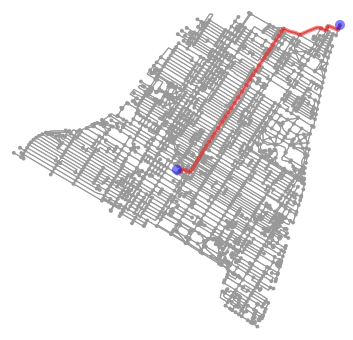

In [80]:
fig, ax = ox.plot_graph_route(graph_proj, route, origin_point=orig_xy, destination_point=target_xy)

7114

In [3]:
df_stations = pd.read_csv('../data/bixi/BixiMontrealRentals2018/Stations_2018.csv')

In [46]:
lat1,lat2 = df_stations['latitude'][[0,8]]
lon1,lon2 = df_stations['longitude'][[0,8]]

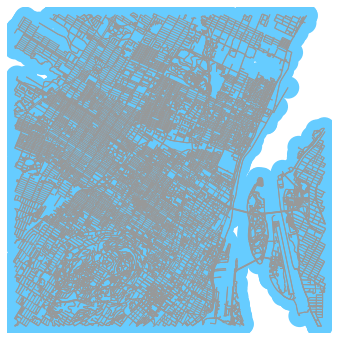

In [13]:
cf = """
     ["area"!~"yes"]
     ["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]
     ["foot"!~"no"]
     ["service"!~"private"]
     ["access"!~"private"]
     """
sg = ox.graph_from_point((lat, lon), distance=5000, custom_filter=cf)
fig, ax = ox.plot_graph(sg, node_size=500)

In [47]:
origin = ox.utils.get_nearest_node(sg, (lat1, lon1))
destination = ox.utils.get_nearest_node(sg, (lat2, lon2))
print(origin)
print(destination)
print(dir(origin))

209473864
437736342
['__abs__', '__add__', '__and__', '__bool__', '__ceil__', '__class__', '__delattr__', '__dir__', '__divmod__', '__doc__', '__eq__', '__float__', '__floor__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getnewargs__', '__gt__', '__hash__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__le__', '__lshift__', '__lt__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rlshift__', '__rmod__', '__rmul__', '__ror__', '__round__', '__rpow__', '__rrshift__', '__rshift__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__trunc__', '__xor__', 'bit_length', 'conjugate', 'denominator', 'from_bytes', 'imag', 'numerator', 'real', 'to_bytes']


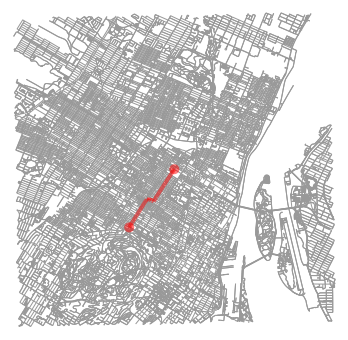

In [48]:
sg_proj = ox.project_graph(sg)
route = nx.shortest_path(sg_proj, source=origin, target=destination, weight = 'length')

fig, ax = ox.plot_graph_route(sg_proj, route, node_size=0, save=True, show=True, filename='my_first_route')

In [56]:
sg.size()
dir(sg)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 '_pred',
 '_succ',
 'add_cycle',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_path',
 'add_star',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_key_dict_factory',
 'edge_subgraph',
 'edges',
 'fresh_copy',
 'get_edge_data',
 'graph',
 'has_edge',
 'has_node',
 'has_predecessor',
 'has_successor',
 'in_degree',
 'in_edges',
 'is_directed',
 'is_multigraph',
 'name',
 'nbunch_iter',
 'neighbors',

In [49]:
G = ox.graph_from_place('Plateau Mont Royal, Montreal, Quebec, Canada', network_type='walk')

In [55]:
G.nodes

NodeView((208863235, 208863242, 208863246, 208863250, 208863257, 208863259, 208863264, 3528679461, 208863270, 208863280, 31776823, 31776824, 31776826, 31776840, 31776848, 31776849, 31776850, 31776851, 476659809, 438329450, 3638089814, 476659828, 476659830, 3638089815, 2148401275, 2148401276, 2148401277, 2148401278, 2148401279, 2148401280, 2148401281, 2148401282, 2148401283, 2148401284, 2148401285, 2148401286, 2148401287, 2148401288, 2148401289, 2148401290, 2148401291, 458940554, 476659844, 476659846, 476659847, 458940552, 458940555, 476659858, 458940563, 458940564, 458940565, 458940562, 458940566, 458940567, 458940560, 1855103136, 1855103137, 31776929, 31776930, 340156578, 1855103141, 340156577, 1855103143, 1855103145, 31776937, 3607797939, 31776949, 31776950, 31776951, 31776952, 31776953, 3642671289, 476659899, 476659900, 476659901, 476659902, 3642671288, 3586048200, 3586048202, 3586048204, 438329549, 438329552, 3567501523, 3567501524, 31776988, 31776989, 31776990, 31776991, 31776992,

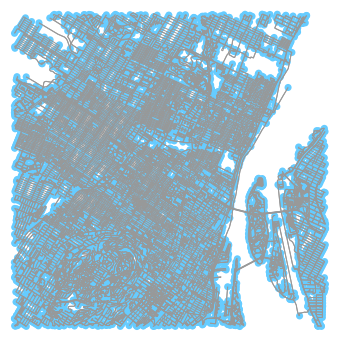

In [15]:
fig,ax = ox.plot_graph(sg,node_size=50)

0.0021911652140631627